
# Projet N°7: Implémentez un modèle de scoring



Data source : Jeu de données d’articles

Inspiré par les Kernels :

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763



## Contexte du projet: 



Société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.
Mission

   - Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
   - Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Le manager incite à sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. L'idée est d'analyser ce kernel pour l'adapter aux besoins de la mission.



In [1]:
#Importation des librairies
import pandas as pd
import seaborn as sns
import glob
import pickle
import os
%pylab inline
import my_module as my

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Les options d'affichage
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000


In [4]:
# Les paramètres des graphiques
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })


# 1. Chargement des données et Analyse exploratoire  

**application_{train|test}.csv**  
Il s’agit du tableau principal, divisé en deux fichiers pour l'entrainement(Train) (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Chaque ligne représente un prêt dans notre échantillon de données.  

**bureau.csv**  
Tous les crédits antérieurs des clients fournis par d’autres institutions financières qui ont été déclarés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait dans le rapport du bureau de crédit avant la date de la demande.  

**bureau_balance.csv**  
Soldes mensuels des crédits antérieurs dans le rapport du bureau de crédit. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur signalé à l’agence d’évaluation du crédit – c.-à-d. le tableau a (#prêts dans l’échantillon #nombre de crédits relatifs précédents #nombre de mois où nous avons des antécédents observables pour les crédits précédents).  

**POS_CASH_balance.csv**  
Aperçus mensuels du solde des anciens POS (point of sales) et des prêts en espèces que le demandeur avait contractés auprès de Crédit à l’habitation. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur au crédit à l’habitation (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c.-à-d. que le tableau a (#Nombre de prêts dans l’échantillon (#Nombre de crédits antérieurs relatifs #Nombre de mois au cours desquels nous avons des antécédents observables pour les crédits précédents)  

**credit_card_balance.csv**  
Instantanés mensuels du solde des cartes de crédit antérieures que le demandeur détient auprès de Crédit à l’habitation. Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit antérieur au crédit à l’habitation (crédit à la consommation et prêts en espèces) lié aux prêts dans notre échantillon – c.-à-d. que le tableau a (#Nombre de prêts dans l’échantillon #Nombre de cartes de crédit antérieures relatives #Nombre de mois où nous avons des antécédents observables pour la carte de crédit précédente)  

**previous_application.csv**  
Toutes les demandes antérieures de crédit à l’habitation de clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.   

**installments_payments.csv**  
Historique de remboursement pour les crédits déjà déboursés dans le crédit à l’habitation liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d’un versement OU d’un versement correspondant à un paiement d’un crédit à l’habitation antérieur lié à des prêts dans notre échantillon. 

**HomeCredit_columns_description.csv**  
Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [5]:
print("CHECKLIST des fichiers dans le dossier Data :")
display(os.listdir('./Data/'))

CHECKLIST des fichiers dans le dossier Data :


['application_test.csv',
 'sample_submission.csv',
 'previous_application.csv',
 'POS_CASH_balance.csv',
 'installments_payments.csv',
 'credit_card_balance.csv',
 'preprocessed_Data',
 'HomeCredit_columns_description.csv',
 'application_train.csv',
 'bureau_balance.csv',
 'bureau.csv']

In [6]:
# chargement des données 

application_train = pd.read_csv('Data/application_train.csv')
application_test = pd.read_csv('Data/application_test.csv')
bureau = pd.read_csv('Data/bureau.csv')
bureau_balance = pd.read_csv('Data/bureau_balance.csv')
credit_card_balance = pd.read_csv('Data/credit_card_balance.csv')
installments_payments = pd.read_csv('Data/installments_payments.csv')
POS_CASH_balance = pd.read_csv('Data/POS_CASH_balance.csv')
previous_application = pd.read_csv('Data/previous_application.csv')

In [7]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [8]:
# chargement de la documentation  

print("DOCUMENTATION :")
description = pd.read_csv('Data/HomeCredit_columns_description.csv')
description

DOCUMENTATION :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [9]:
# signification de la variables "target"
description['Description'][1]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [10]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("SUMMARY FILES ")
    return(comparative_table)


In [11]:
# statistique  des différents fichiers
print('statistique  des différents fichiers')
data_describe(glob.glob('./Data/*.csv'))

statistique  des différents fichiers
SUMMARY FILES 


,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
./Data/application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
./Data/sample_submission.csv,48744,2,0.00,0.0,0,1,1,0,0.744
./Data/previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
./Data/POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
./Data/installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
./Data/credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
./Data/HomeCredit_columns_description.csv,219,5,12.15,0.0,4,0,1,0,0.008
./Data/application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
./Data/bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846
./Data/bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620


In [12]:
def variable_stats(folder):
    '''
    fonction qui effectue des statistiques des variables de type object et des variables numériques
    Retourne deux dataframes: 
    - 1 dataframe de statistique des variables object
    - 1 dataframe de statistique des variables numériques
    '''
    
    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file)
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

In [13]:
# description des variables de type object

variable_stats(folder=glob.glob('./Data/*.csv'))[0]

features  \
./Data/application_test.csv               0            NAME_CONTRACT_TYPE   
                                          1                   CODE_GENDER   
                                          2                  FLAG_OWN_CAR   
                                          3               FLAG_OWN_REALTY   
                                          4               NAME_TYPE_SUITE   
                                          5              NAME_INCOME_TYPE   
                                          6           NAME_EDUCATION_TYPE   
                                          7            NAME_FAMILY_STATUS   
                                          8             NAME_HOUSING_TYPE   
                                          9               OCCUPATION_TYPE   
                                          10   WEEKDAY_APPR_PROCESS_START   
                                          11            ORGANIZATION_TYPE   
                                          12           FONDKAPREMONT_MODE   
                                          13               HOUSETYPE_MODE   
                                          14           WALLSMATERIAL_MODE   
                                          15          EMERGENCYSTATE_MODE   
./Data/previous_application.csv           0            NAME_CONTRACT_TYPE   
                                          1    WEEKDAY_APPR_PROCESS_START   
                                          2   FLAG_LAST_APPL_PER_CONTRACT   
                                          3        NAME_CASH_LOAN_PURPOSE   
                                          4          NAME_CONTRACT_STATUS   
                                          5             NAME_PAYMENT_TYPE   
                                          6            CODE_REJECT_REASON   
                                          7               NAME_TYPE_SUITE   
                                          8              NAME_CLIENT_TYPE   
                                          9           NAME_GOODS_CATEGORY   
                                          10               NAME_PORTFOLIO   
                                          11            NAME_PRODUCT_TYPE   
                                          12                 CHANNEL_TYPE   
                                          13         NAME_SELLER_INDUSTRY   
                                          14             NAME_YIELD_GROUP   
                                          15          PRODUCT_COMBINATION   
./Data/POS_CASH_balance.csv               0          NAME_CONTRACT_STATUS   
./Data/credit_card_balance.csv            0          NAME_CONTRACT_STATUS   
./Data/HomeCredit_columns_description.csv 0                         Table   
                                          1                           Row   
                                          2                   Description   
                                          3                       Special   
./Data/application_train.csv              0            NAME_CONTRACT_TYPE   
                                          1                   CODE_GENDER   
                                          2                  FLAG_OWN_CAR   
                                          3               FLAG_OWN_REALTY   
                                          4               NAME_TYPE_SUITE   
                                          5              NAME_INCOME_TYPE   
                                          6           NAME_EDUCATION_TYPE   
                                          7            NAME_FAMILY_STATUS   
                                          8             NAME_HOUSING_TYPE   
                                          9               OCCUPATION_TYPE   
                                          10   WEEKDAY_APPR_PROCESS_START   
                                          11            ORGANIZATION_TYPE   
                                          12           FONDKAPREMONT_MODE   
                                          13               HO

In [14]:
# description des variables numériques 

variable_stats(folder=glob.glob('./Data/*.csv'))[1]

features  \
./Data/application_test.csv               0                      SK_ID_CURR   
                                          1                    CNT_CHILDREN   
                                          2                AMT_INCOME_TOTAL   
                                          3                      AMT_CREDIT   
                                          4                     AMT_ANNUITY   
                                          5                 AMT_GOODS_PRICE   
                                          6      REGION_POPULATION_RELATIVE   
                                          7                      DAYS_BIRTH   
                                          8                   DAYS_EMPLOYED   
                                          9               DAYS_REGISTRATION   
                                          10                DAYS_ID_PUBLISH   
                                          11                    OWN_CAR_AGE   
                                          12                     FLAG_MOBIL   
                                          13                 FLAG_EMP_PHONE   
                                          14                FLAG_WORK_PHONE   
                                          15               FLAG_CONT_MOBILE   
                                          16                     FLAG_PHONE   
                                          17                     FLAG_EMAIL   
                                          18                CNT_FAM_MEMBERS   
                                          19           REGION_RATING_CLIENT   
                                          20    REGION_RATING_CLIENT_W_CITY   
                                          21        HOUR_APPR_PROCESS_START   
                                          22     REG_REGION_NOT_LIVE_REGION   
                                          23     REG_REGION_NOT_WORK_REGION   
                                          24    LIVE_REGION_NOT_WORK_REGION   
                                          25         REG_CITY_NOT_LIVE_CITY   
                                          26         REG_CITY_NOT_WORK_CITY   
                                          27        LIVE_CITY_NOT_WORK_CITY   
                                          28                   EXT_SOURCE_1   
                                          29                   EXT_SOURCE_2   
                                          30                   EXT_SOURCE_3   
                                          31                 APARTMENTS_AVG   
                                          32               BASEMENTAREA_AVG   
                                          33    YEARS_BEGINEXPLUATATION_AVG   
                                          34                YEARS_BUILD_AVG   
                                          35                 COMMONAREA_AVG   
                                          36                  ELEVATORS_AVG   
                                          37                  ENTRANCES_AVG   
                                          38                  FLOORSMAX_AVG   
                                          39                  FLOORSMIN_AVG   
                                          40                   LANDAREA_AVG   
                                          41           LIVINGAPARTMENTS_AVG   
                                          42                 LIVINGAREA_AVG   
                                          43        NONLIVINGAPARTMENTS_AVG   
                                          44              NONLIVINGAREA_AVG   
                                          45                APARTMENTS_MODE   
                                          46              BASEMENTAREA_MODE   
                                          47   YEARS_BEGINEXPLUATATION_MODE   
                                          48               YEARS_BUILD_MODE   
                                          49                COMMONAREA_MODE   
                                      

## Analyse approfondue des principaux fichiers application_{train|test}

In [15]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [49]:
# sauvegarder un échatillon des données test avant le prétraitement pour en servir dans le dashbord
application_test_sample = application_test.head(100)
application_test_sample.to_csv('test_sample_brute.csv')  

In [16]:
# Verifier si la variable "target" est la seule différence entre les deux df
display(application_train.columns.difference(application_test.columns))

Index(['TARGET'], dtype='object')

#### Etude de la variable "Target"

In [17]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

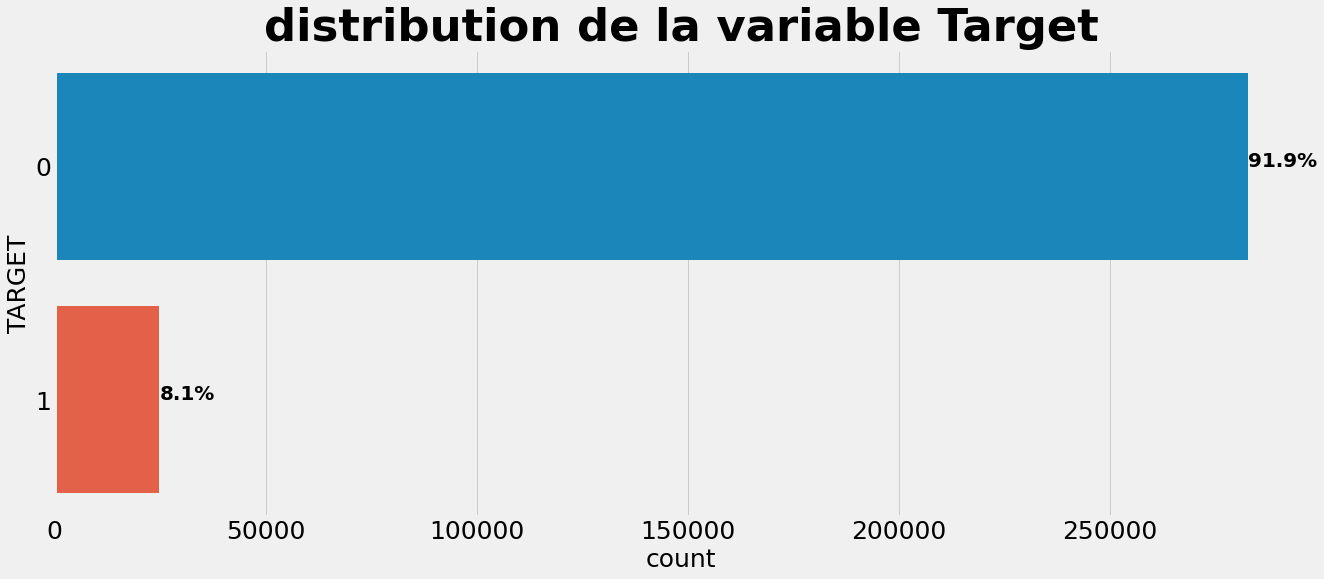

In [18]:
# afficher la distribution de "target"  

ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("distribution de la variable Target")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
show()

### Remarque:  
Nous remarquons qu'il y a deux classes déséquilibrées
Notons des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps ( Target = 0) que de prêts non remboursés (Target = 1) .   

Cette information peut nous être très utile dans l'étape de modélisation.   

### Type de colonnes

In [19]:
application_train.dtypes.value_counts()


float64    65
int64      41
object     16
dtype: int64

In [20]:
# vérifier les valeurs uniques dans les variables de type object à encoder après
application_train.select_dtypes('object').nunique()


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

--> Nous pouvons dire qu'il y a un nombre de valeurs uniques relativement petit et donc possible à encoder  

### Valeurs manquantes

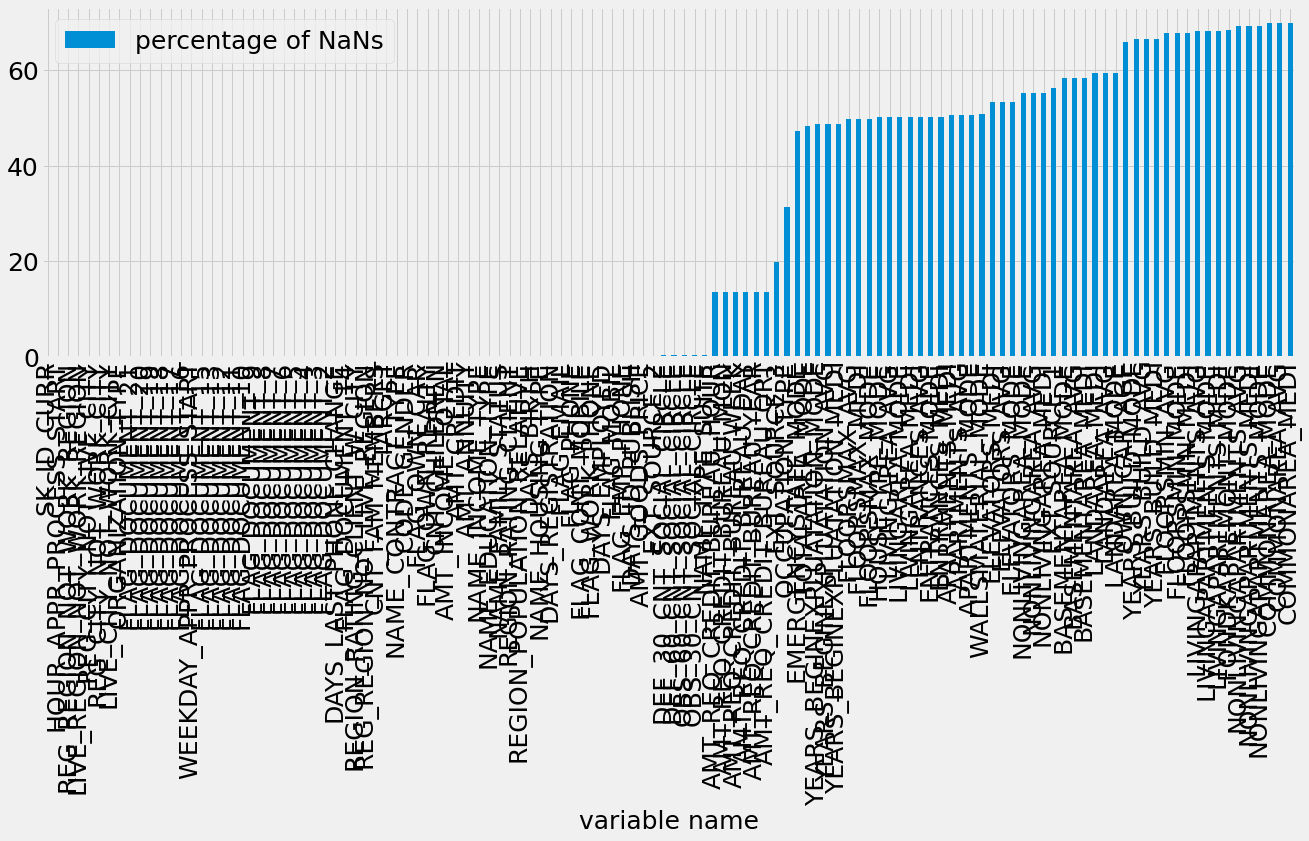

In [21]:
my.nans_df(application_train)

--> Nous notons une difficulté de savoir quelles variables ont plus de nans que les autres vu le grand nombre de variables. Nous allons donc vérifier le top 15 des Nans dans la cellule suivante.

In [22]:
# vérifier les variables qui ont plus de nan
def nan_check(data):
    '''vérifier les données manquantes'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 15 des données manquantes')
nan_check(application_train)[:15]

TOP 15 des données manquantes


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


--> Nous remarquons que les nans sont plus présents dans les caractéristiques des habitats et non sur les crédits. 

In [22]:
# vérifier le nombre de colonnes contenant des nans

print("nombre de colonnes total dans l'échantillon d'entrainement: " + str(len(nan_check(application_train))))

print("nombre de colonnes dans l'échantillon d'entrainement avec des valeurs manquantes: " + 
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))


nombre de colonnes total dans l'échantillon d'entrainement: 122
nombre de colonnes dans l'échantillon d'entrainement avec des valeurs manquantes: 67


### Gestion des outliers

In [23]:
# vérifier l'age des clients qui est calculé en nombre de jours
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

--> Nous remarquons qu'il y a des valeurs négatives car elles sont enregistrées par rapport à la demande de prêt en cours. . Nous allons les rectifier. 

In [24]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

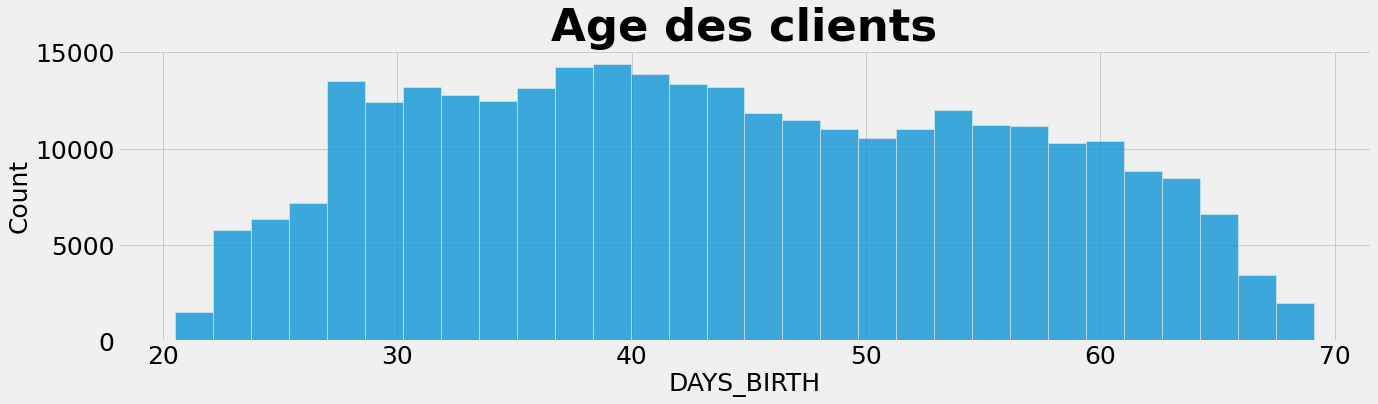

In [25]:
# distribution d'âge des clientsdes
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age des clients')
show()

In [26]:
# La variable 'DAYS_EMPLOYED' - signification
description['Description'][18]

'How many days before the application the person started current employment'

In [27]:
# vérifier la variable dans l'échantillon d'entrainement
application_train['DAYS_EMPLOYED'].describe()


count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

--> Présence des valeurs négatives. Nous allons les rectifier. 

In [28]:
# vérifier la variable dans l'échantillon de test
application_test['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Nous remarquons qu'il y a des valeurs extrême qui ne sont pas logiques : 1000 années (365243/365j). Vérifions s'il s'agit d'une valeur aberrante isolée ou bien de plusieurs échantillons. 

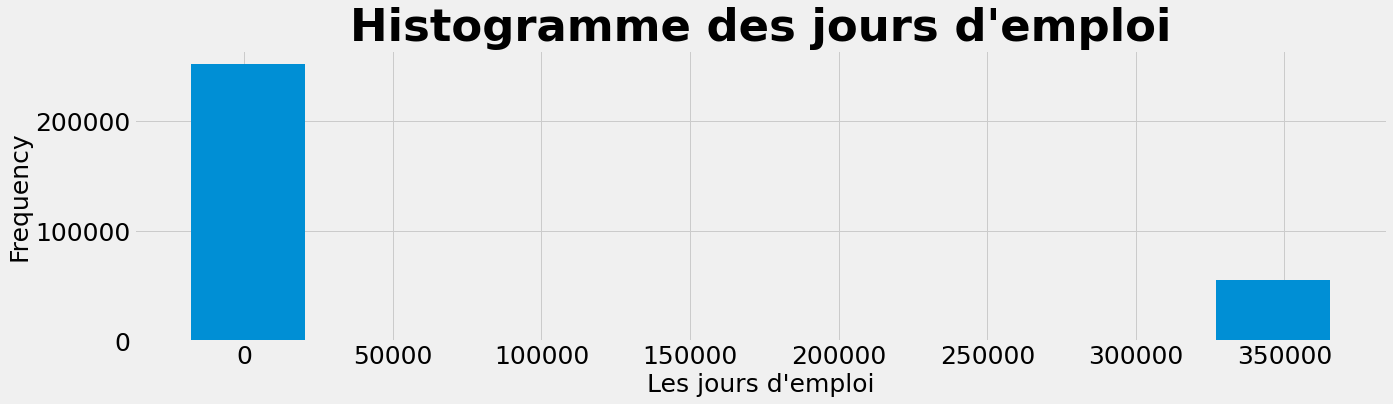

In [29]:
application_train['DAYS_EMPLOYED'].plot.hist(title = "Histogramme des jours d'emploi", figsize=(20,5));
plt.xlabel("Les jours d'emploi")
show()

In [30]:
print("%0.0f valeur totale des jours de travail dans les données d'entrainement" % application_train.shape[0])
print("%0.0f valeurs avec 365243 jours de travail dans les données d'entrainement" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))

print("\n\n")
print("%0.0f valeur totale des jours de travail dans les données de test" % application_test.shape[0])
print("%0.0f valeurs avec 365243 jours de travail dans les données de test" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))


307511 valeur totale des jours de travail dans les données d'entrainement
55374 valeurs avec 365243 jours de travail dans les données d'entrainement



48744 valeur totale des jours de travail dans les données de test
9274 valeurs avec 365243 jours de travail dans les données de test


--> cette valeur aberrante n'est pas une valeur isolée. Nous allons la remplacer pas np.nan. 

In [23]:
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

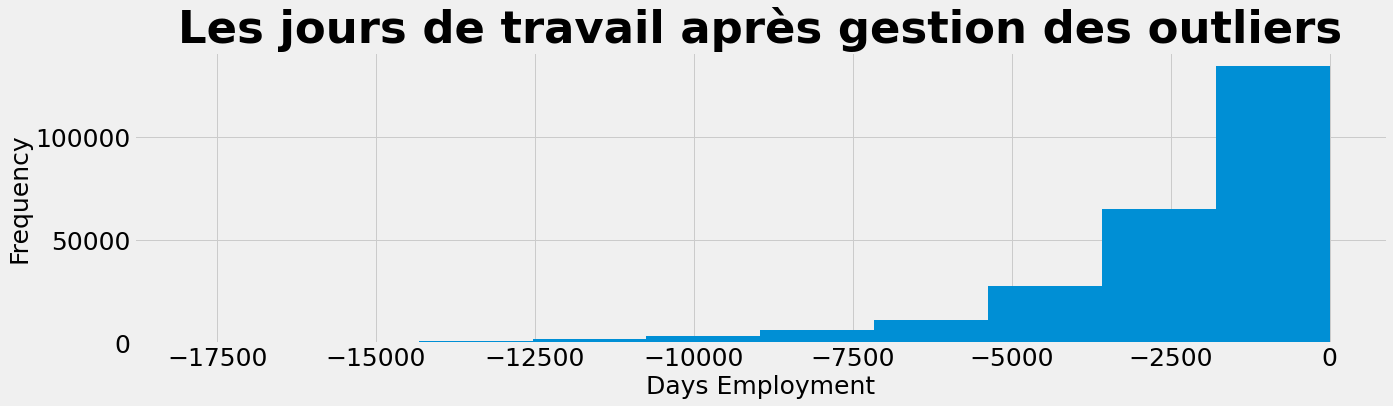

In [24]:
# remplacer la valeur aberrate par nan 
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# re-afficher l'histogramme après le remplacement
application_train['DAYS_EMPLOYED'].plot.hist(title ='Les jours de travail après gestion des outliers', figsize=(20,5))
plt.xlabel('Days Employment')
show()


In [33]:
application_test['DAYS_EMPLOYED'].describe()

count    39470.000000
mean     -2476.738941
std       2307.963913
min     -17463.000000
25%      -3328.750000
50%      -1765.000000
75%       -861.000000
max         -1.000000
Name: DAYS_EMPLOYED, dtype: float64

# Analyse univariée et multi-variée

#### Analyse descriptive des principaux variables  
Dans cette partie, nous allons mettre l'accent sur les principaux variables qui permettent d'orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.

In [34]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.4f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()


In [35]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage avec prêt non remboursé (trget = 1)")

    for p in ax.patches:
                percentage = '{:.4f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()


1. **Type de prêt** - Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET 1(prêt non retourné).

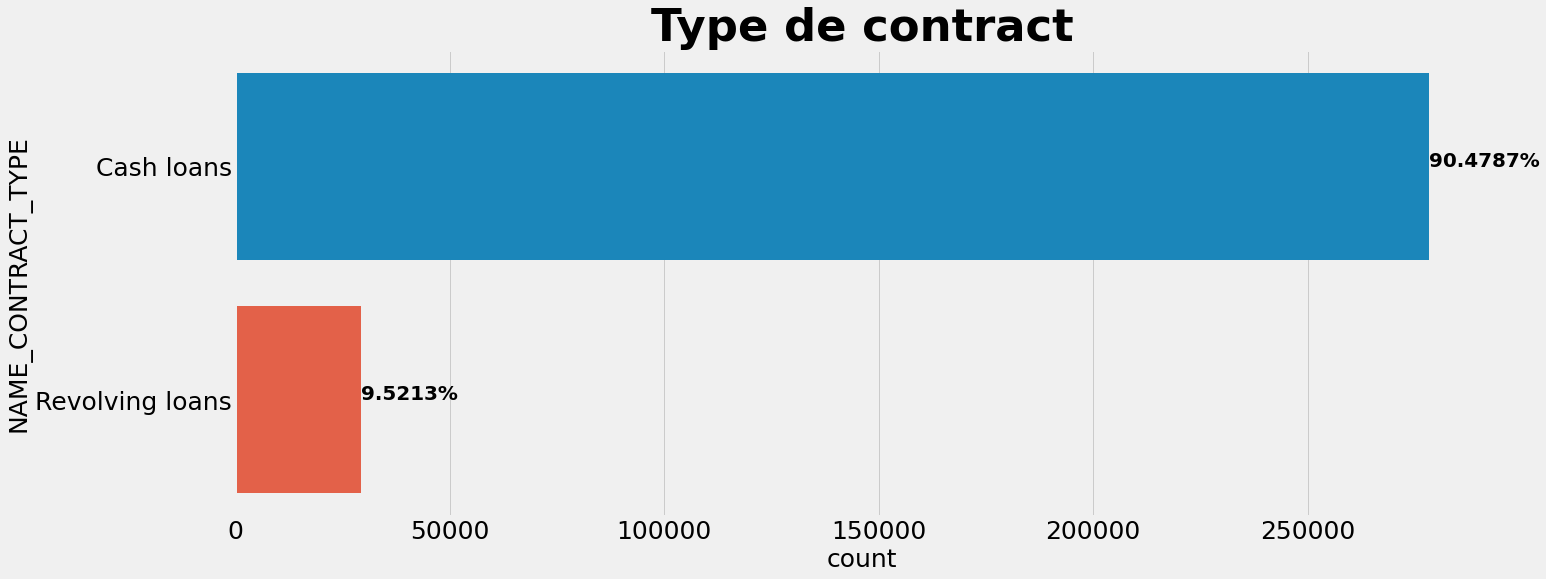

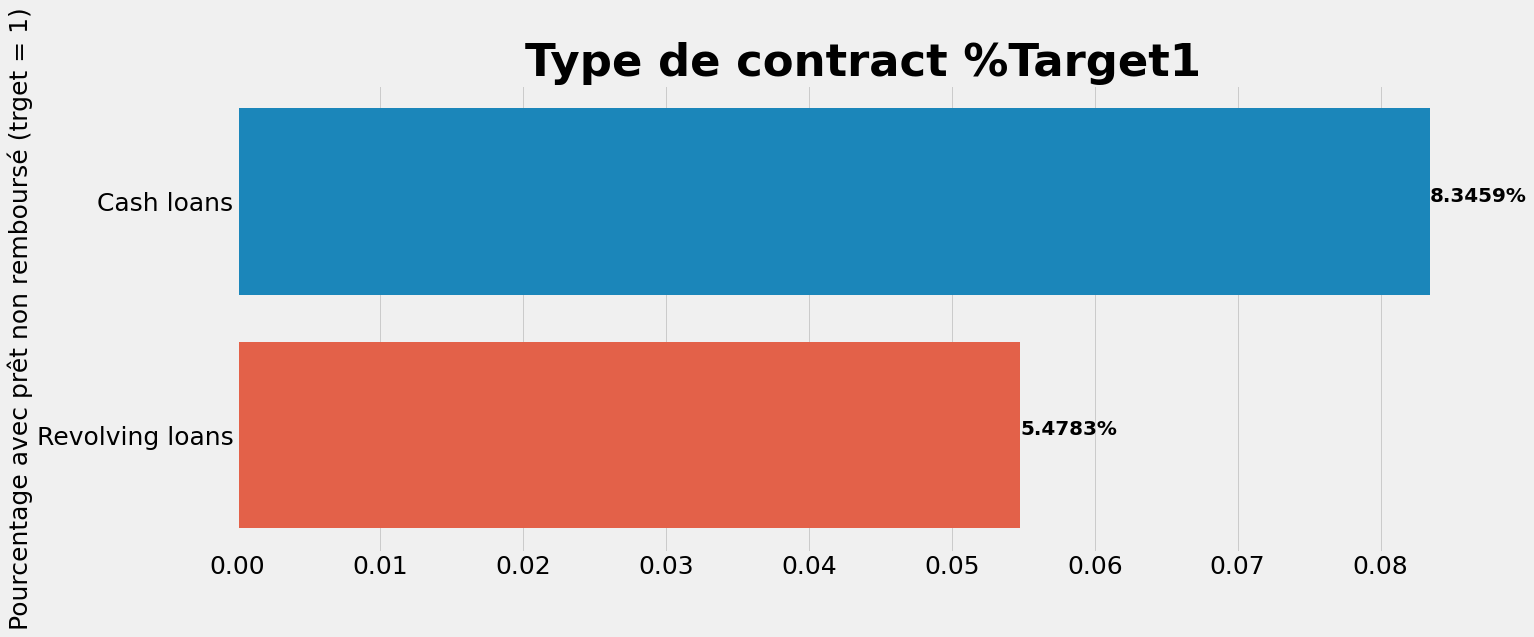

In [36]:
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type de contract")
print(" \n\n")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type de contract %Target1")

--> Les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

2. **genre du client** - Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non retourné).

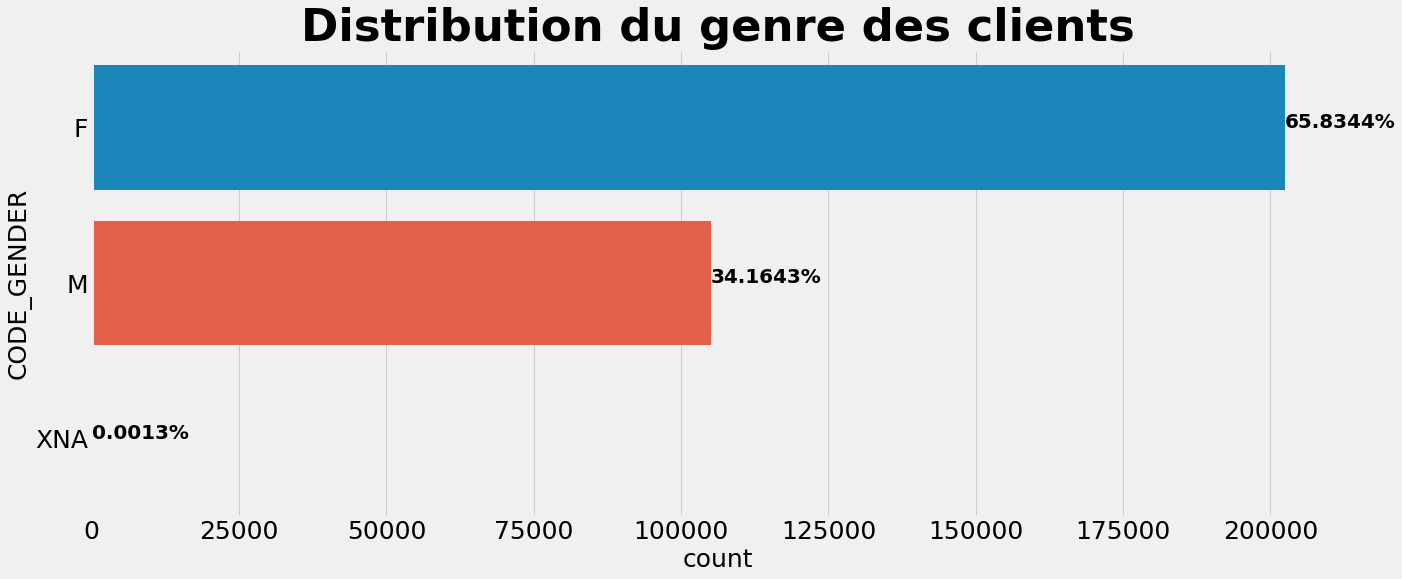

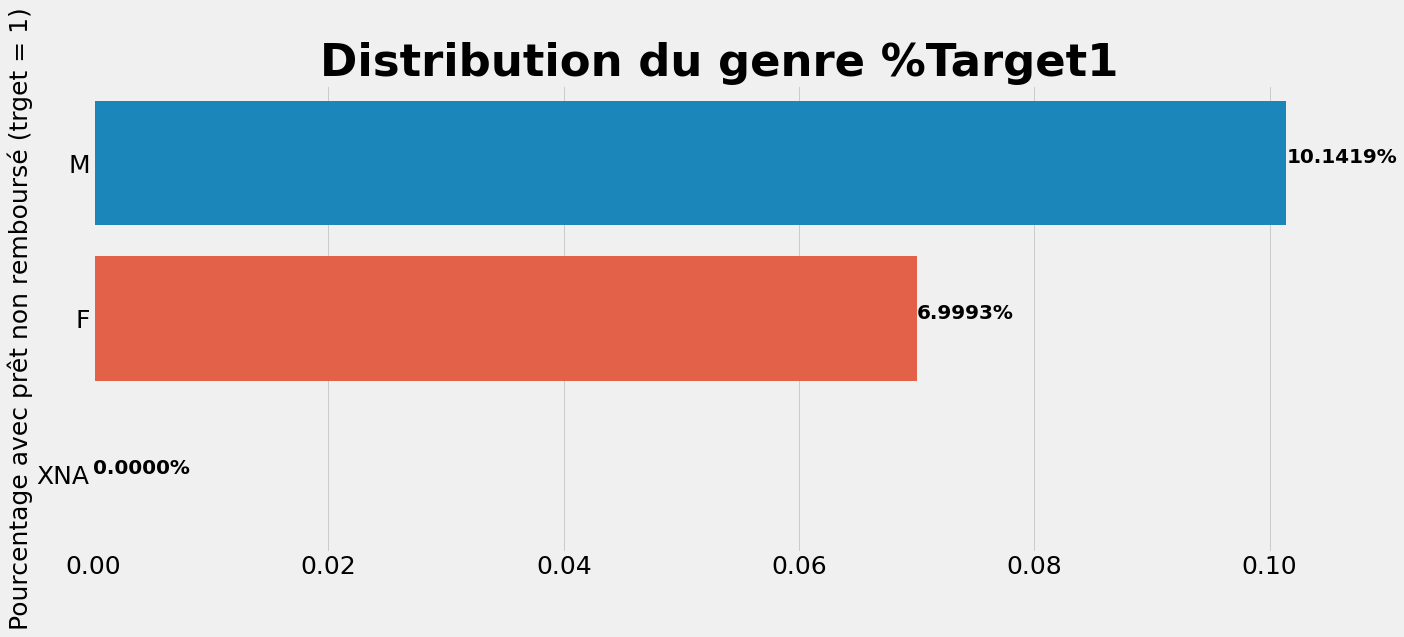

In [37]:
plot_stat(application_train, 'CODE_GENDER',"Distribution du genre des clients")
print("\n\n")
plot_percent_target1(application_train, 'CODE_GENDER',"Distribution du genre %Target1")

Le nombre femme est presque le double du nombre des hommes qui ont emprunté des crédits. En ce qui concerne le pourcentage de crédits non reboursés, les hommes ont plus de mal à rembourser leurs prêts (10%), comparativement aux femmes (7%).

3. **Possession d'une voiture** - Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas. 

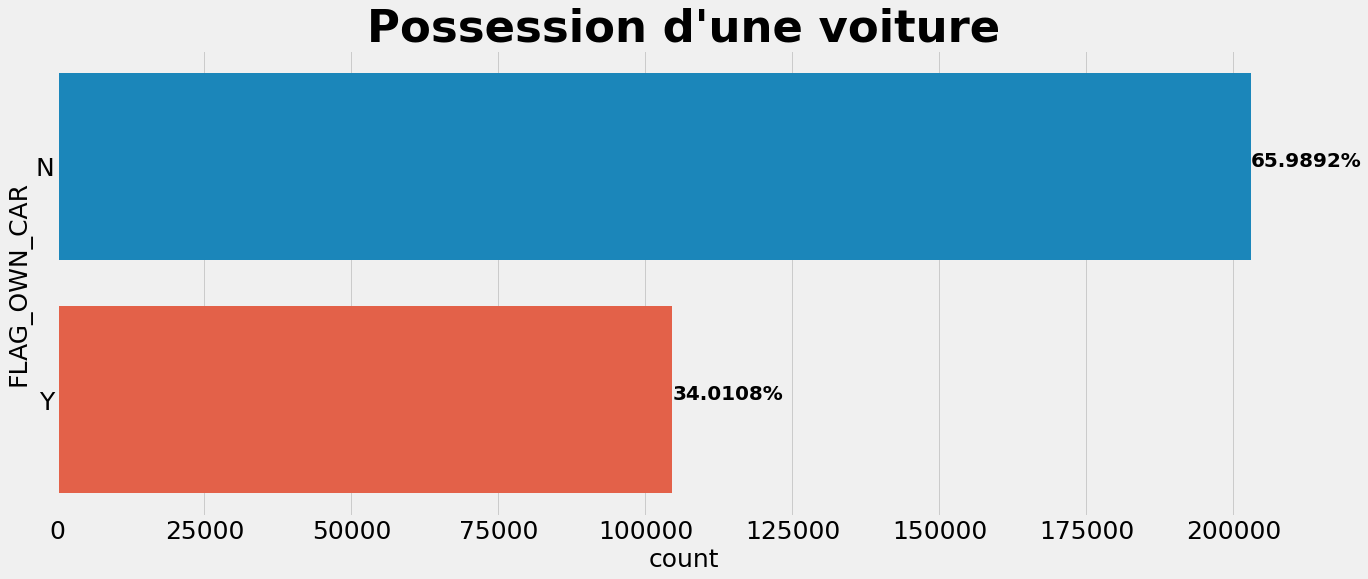

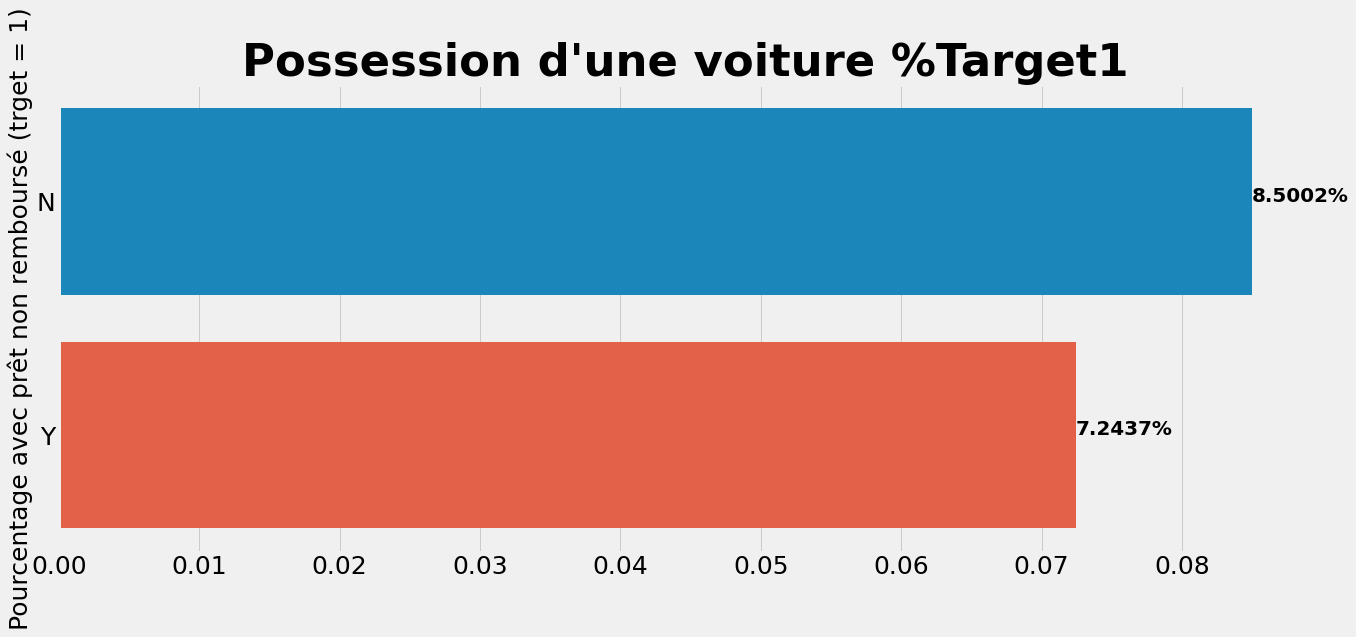

In [38]:
plot_stat(application_train, 'FLAG_OWN_CAR',"Possession d'une voiture")
print("\n\n")
plot_percent_target1(application_train, 'FLAG_OWN_CAR',"Possession d'une voiture %Target1")



--> Les deux catégories (propriétaire ou non d'une voiture) ont des taux de non-remboursement assez proche: environ 8%.

4. **Statut familial** : 

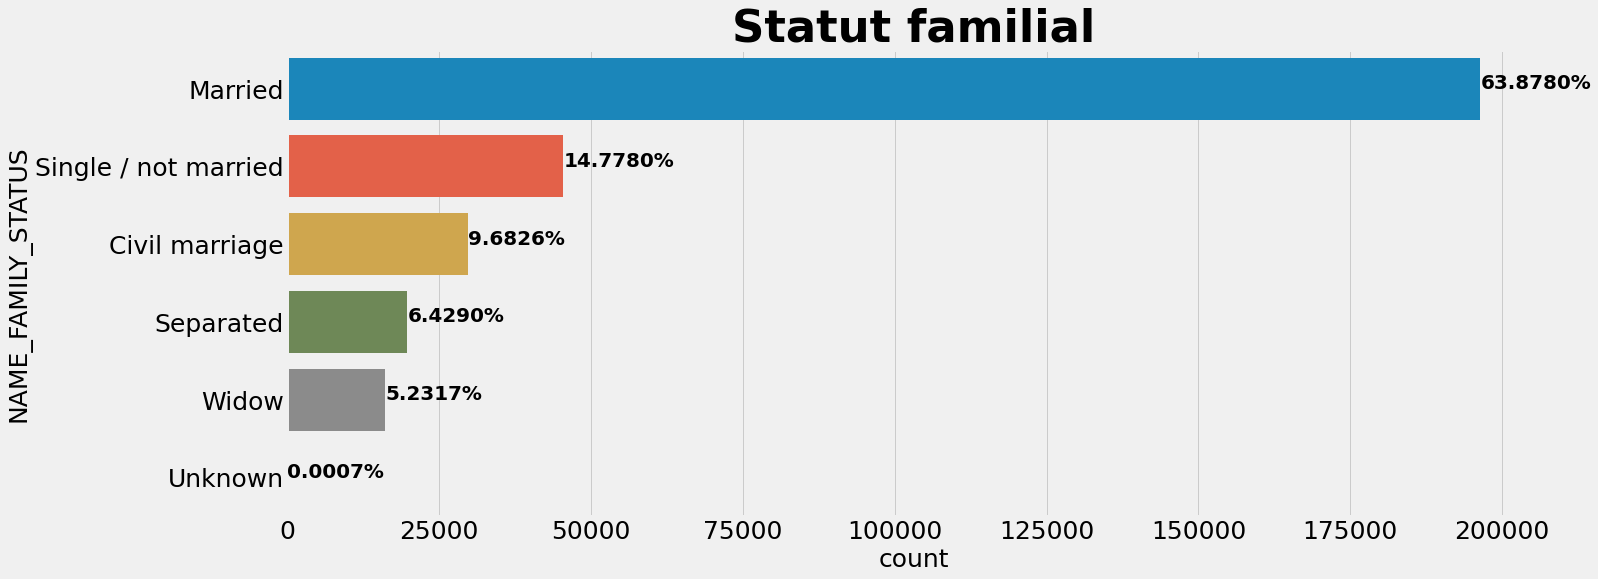

                                   -------------------------------------------------------


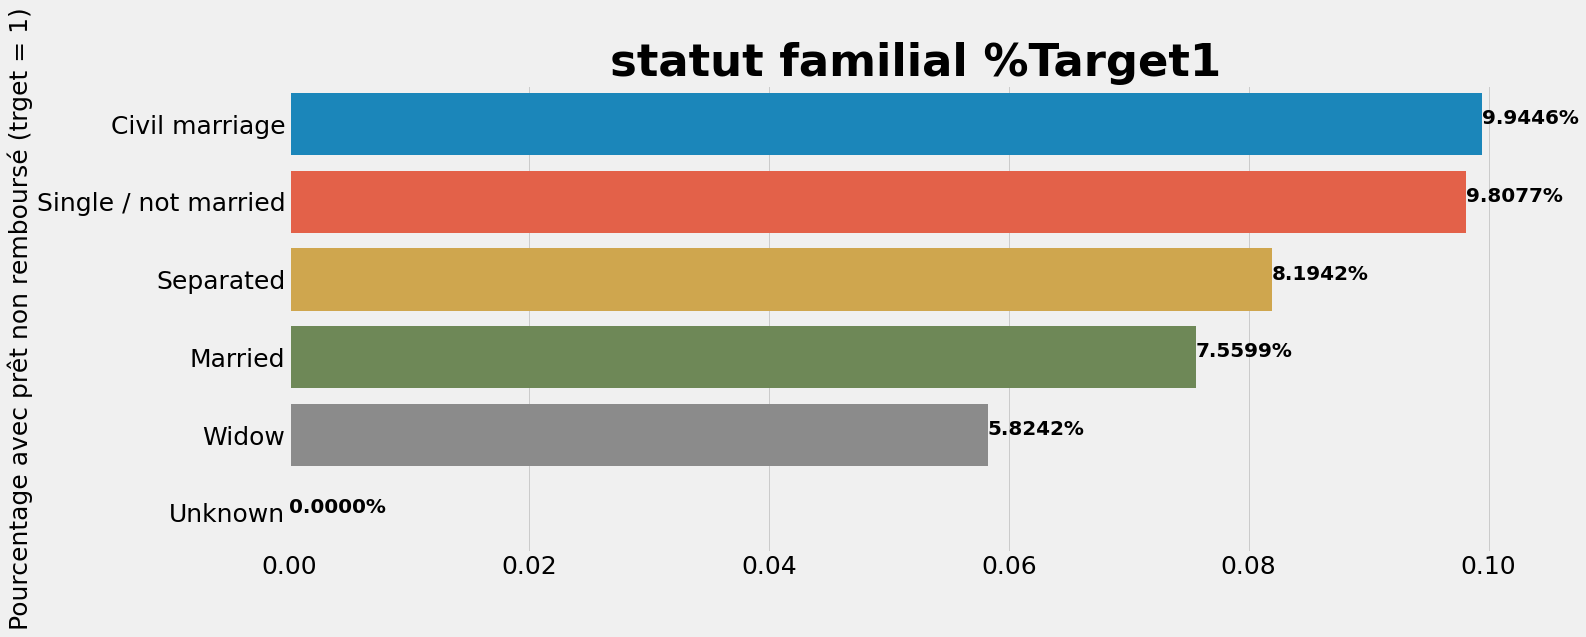

In [39]:
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Statut familial")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"statut familial %Target1")

--> La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.

En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).


- 5. **Type des revenus des clients**

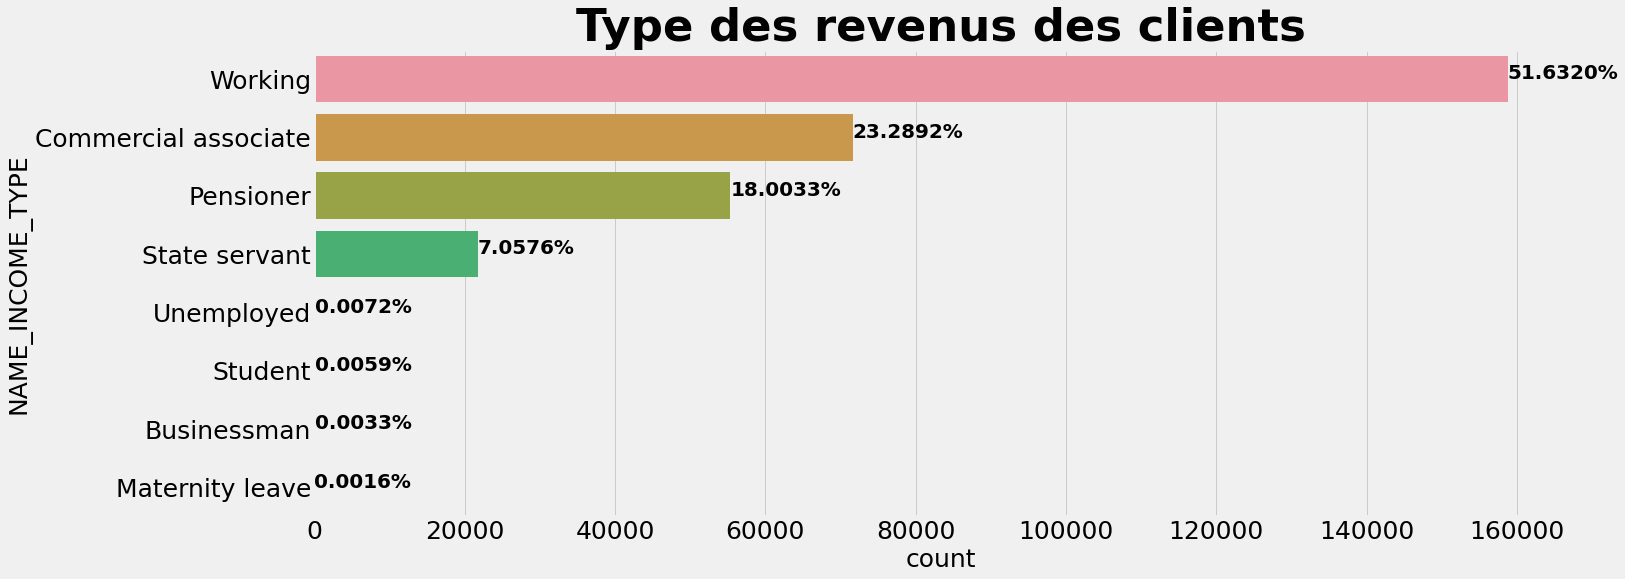

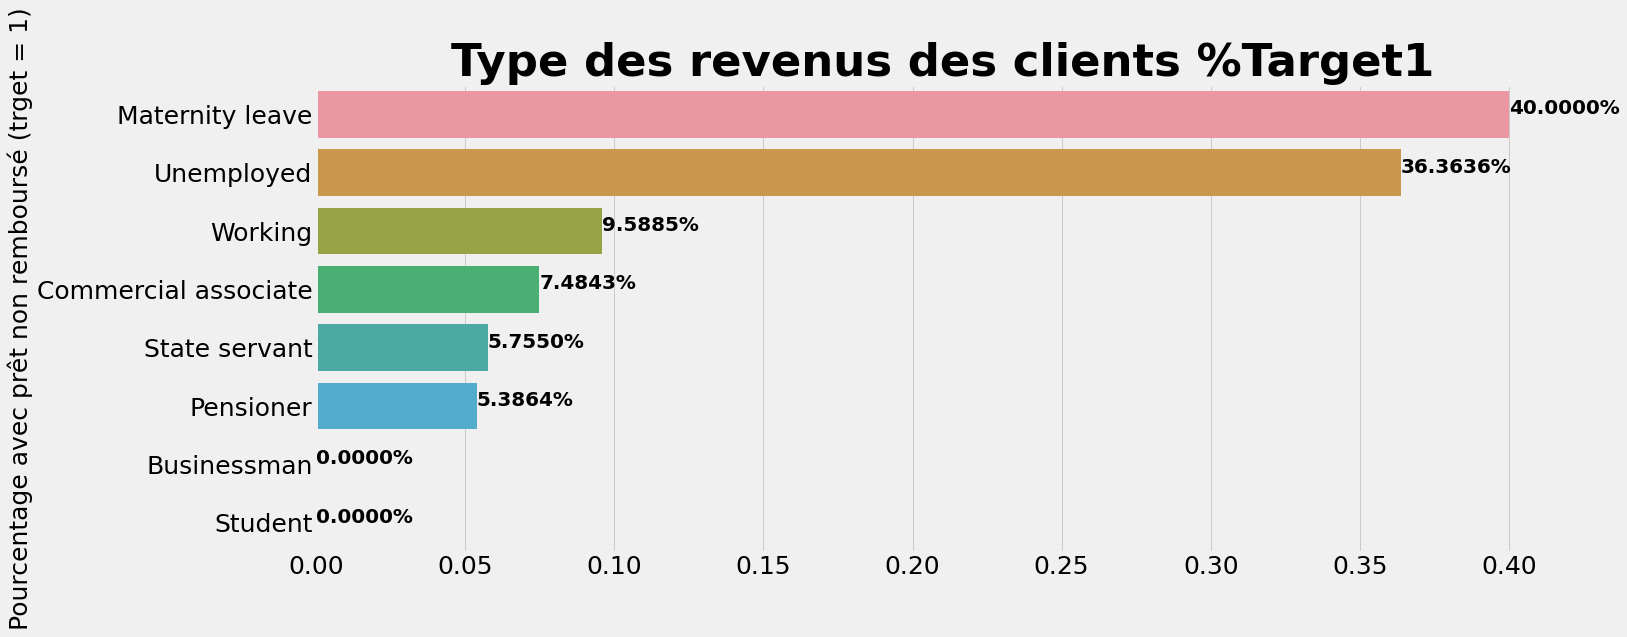

In [40]:
plot_stat(application_train, 'NAME_INCOME_TYPE',"Type des revenus des clients")
print("\n\n")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Type des revenus des clients %Target1")


--> La plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.

Les demandeurs avec le type de revenu Congé de maternité ont un pourcentage de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à 10% pour ne pas rembourser leurs prêts.


- 6. **Occupation des clients**

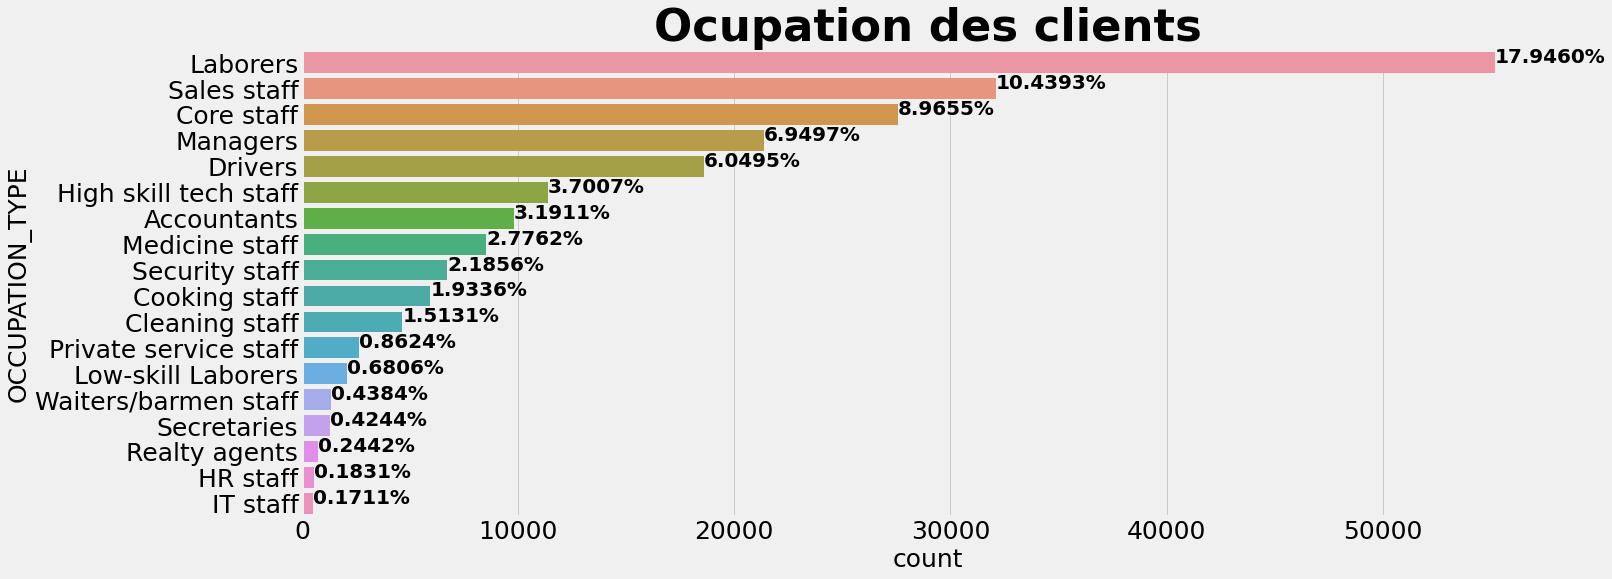

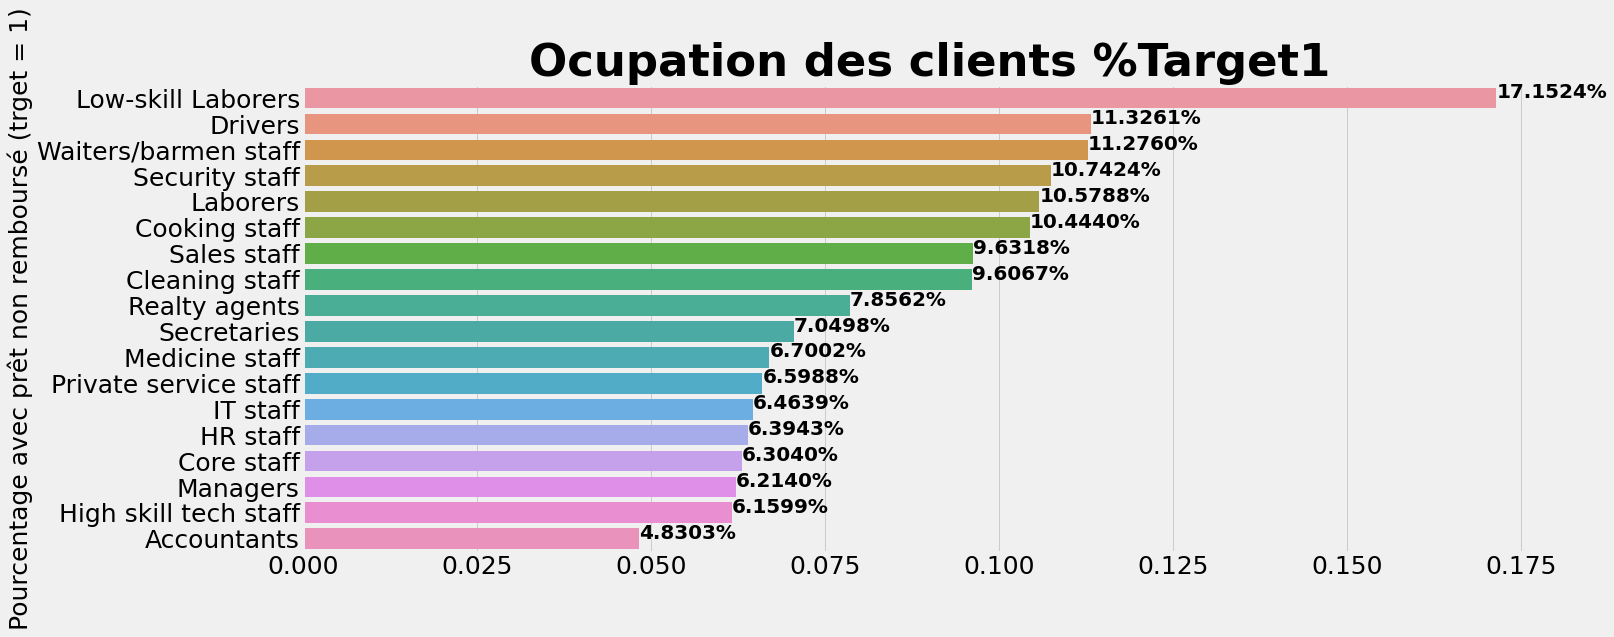

In [41]:
plot_stat(application_train, 'OCCUPATION_TYPE',"Ocupation des clients")
print("\n\n")
plot_percent_target1(application_train, 'OCCUPATION_TYPE',"Ocupation des clients %Target1")

--> La plupart des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux. 

La catégorie ayant plus de difficulté à rembourser leur prêts est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.


- 7. **Niveau d'éducation des clients** 

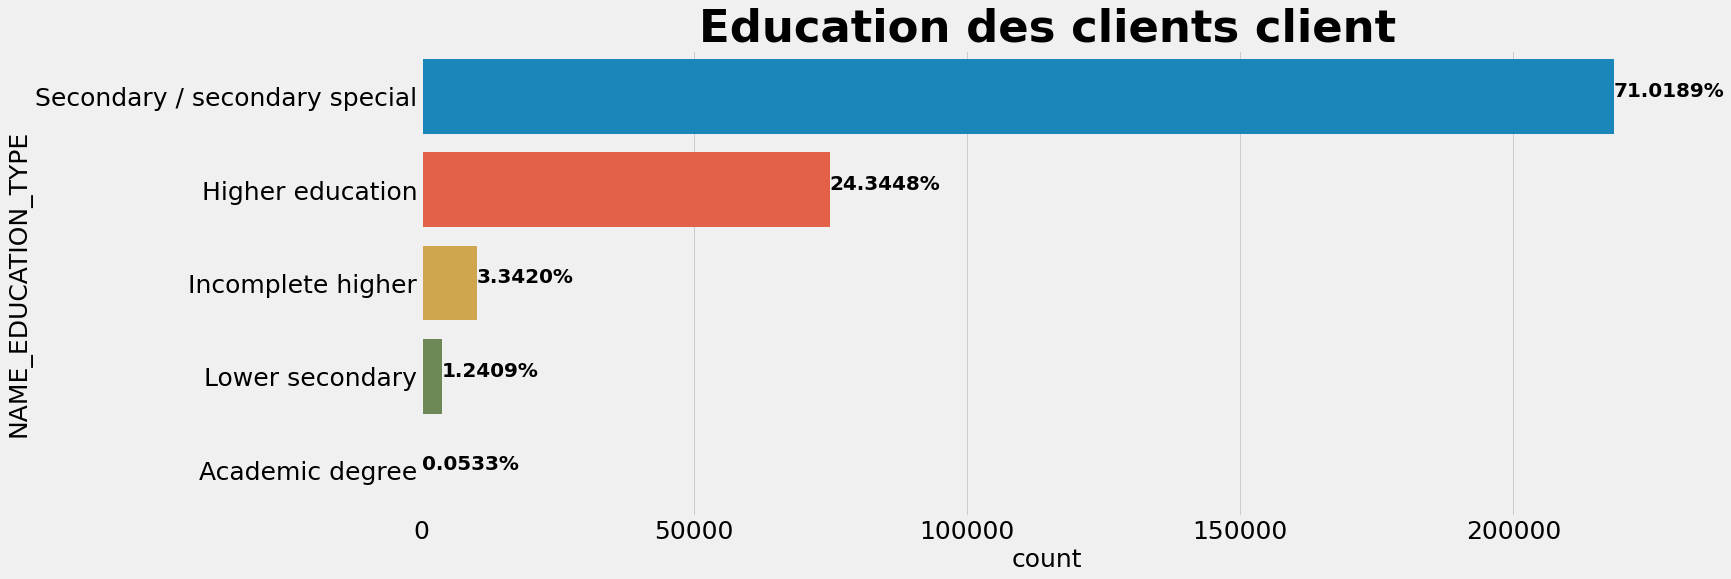

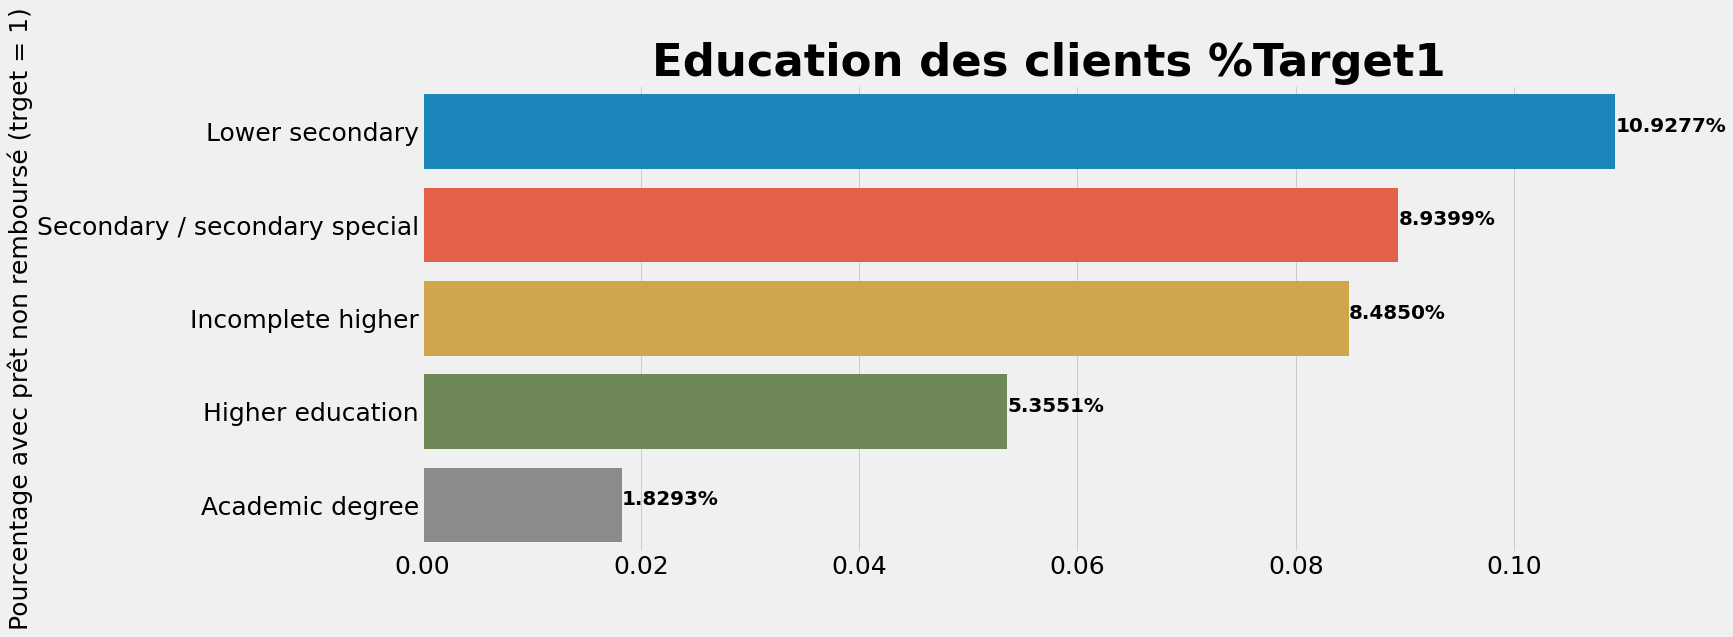

In [42]:
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Education des clients client")
print("\n\n")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Education des clients %Target1")



--> La majorité des clients ont une éducation secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.


-**8. Type d'habitat**

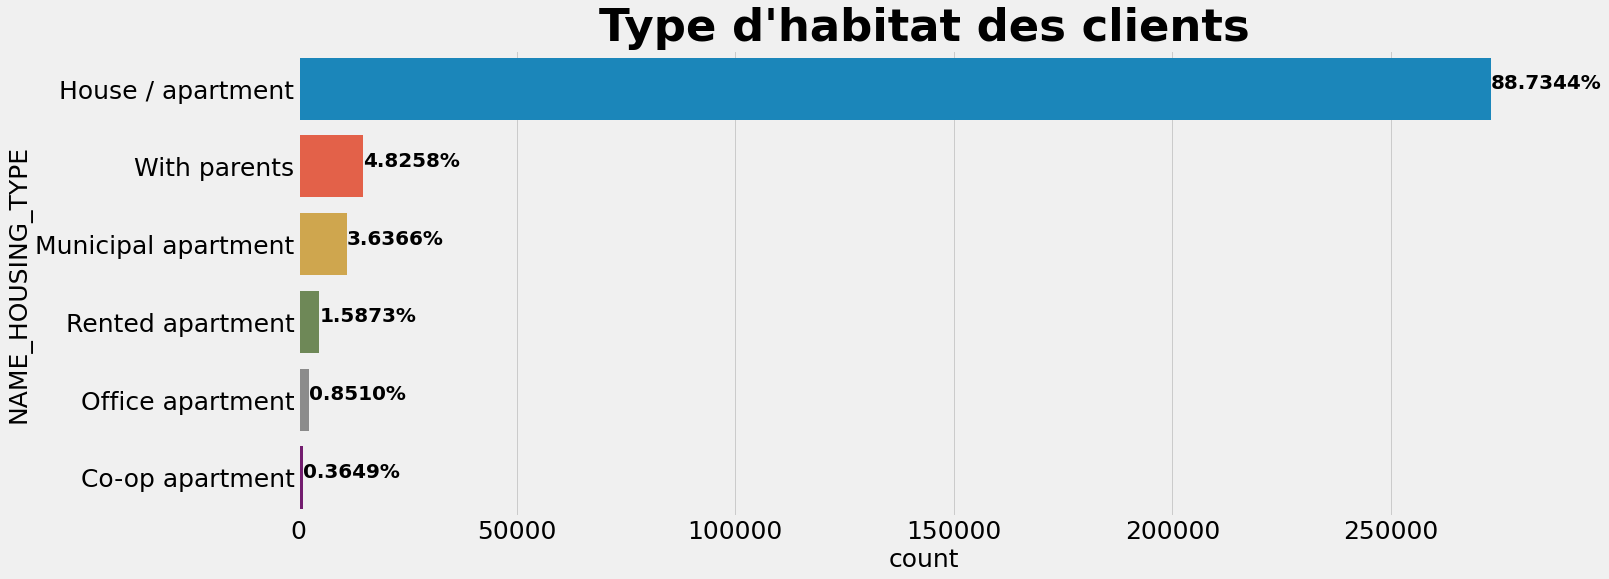

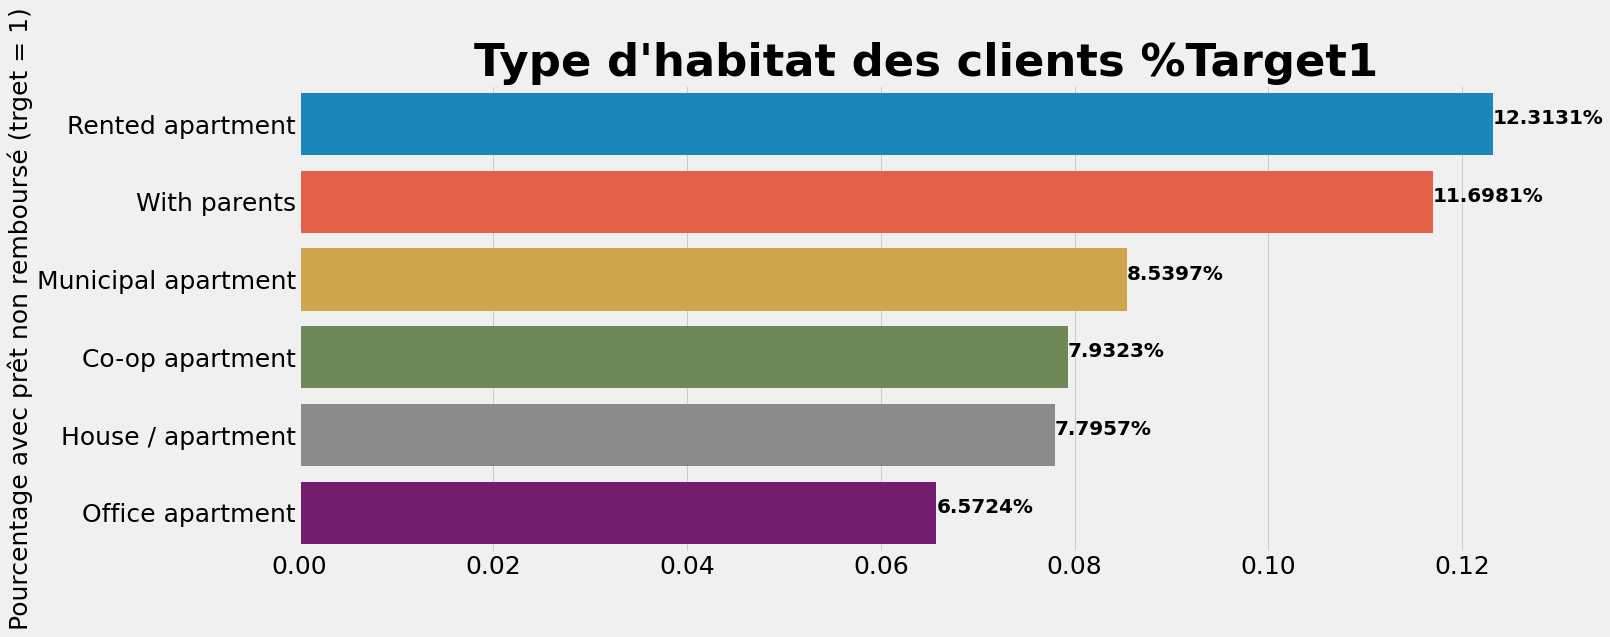

In [43]:
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type d'habitat des clients")
print("\n\n")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type d'habitat des clients %Target1")


--> Plus de 88% de demandeurs de crédits vivent en maison ou appartement. Les catégories ayant un faible pourcentage, représentent une population moins "indépendante" (vivre chez ses parents, etc…).

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.


# Feature engineering

In [25]:
#Création d'un simple dataset avec train / test merge app
data = application_train.append(application_test)

Calcul du nombre total des précédents crédits pris par chaque client. Ce type d'information viendra enrichir l'échantillon de travail…

In [26]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [27]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape


(356255, 124)

Création de 5 nouvelles variables métiers :  

- **CREDIT_INCOME_PERCENT**: Pourcentage du montant du crédit par rapport au revenu d'un client  
- **ANNUITY_INCOME_PERCENT**: Pourcentage de la rente de prêt par rapport au revenu d'un client  
- **CREDIT_TERM**: Durée du paiement en mois  
- **DAYS_EMPLOYED_PERCENT**: Pourcentage des jours employés par rapport à l'âge du client  
- **INCOME_PER_PERSON**: pourcentage des revenues des clients par rapport aux membres de la famille.

In [28]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [48]:
#verifier le nombre de variables après feature engineering
data.shape

(356255, 129)

In [49]:
print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))


Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_PERCENT        -0.067955
DAYS_EMPLOYED_OUTLIERS       -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MOD

# Prétraitement des données  

Dans cette partie, nous allons:  
- re-séparer les données test et les données d'entrainement.  
- encodage des variables catégorielles  
- imputation des nan  
- standardisation des données

### 1. Train/ test data

In [29]:
# rappel avec les dataframes application_train et application_test.
data_train = data[data['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]


In [51]:
data_train.shape

(307511, 129)

In [52]:
data_test.shape

(48744, 129)

In [30]:
# supprimer la variable "target" de data_test
data_test = data_test.drop('TARGET', axis=1)

In [31]:
data_train.set_index('SK_ID_CURR', inplace=True)

In [32]:
data_test.set_index('SK_ID_CURR', inplace=True)

In [56]:
print("taille de df d'entrainement: ", data_train.shape)
print('taille de df de test: ', data_test.shape)

taille de df d'entrainement:  (307511, 128)
taille de df de test:  (48744, 127)


In [57]:
# SAUVEGARDER LES DONNÉES TEST AVANT PRETRAITEMENT
data_test.to_csv('Data/preprocessed_Data/data_test_unprocessed.csv')  

In [58]:
data_test.shape

(48744, 127)

### 2. Encodage des variables catégorielles

In [33]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [60]:
data_train.shape

(307511, 252)

In [61]:
data_test.shape

(48744, 248)

In [34]:
# vérifions les variables qui sont différents
display(data_train.columns.difference(data_test.columns))

Index(['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown',
       'NAME_INCOME_TYPE_Maternity leave', 'TARGET'],
      dtype='object')

--> il faut aligner les deux df (supprimer les différences) sauf pour la variable "TARGET" qu'on doit la sauvegarder tout d'abord.

In [35]:
#sauvegarder la variable "TARGET"
TARGET = data_train.TARGET 
# supprimer "TARGET" avant de faire l'alignement des deux dataframes
data_train.drop('TARGET', axis=1, inplace=True) 

In [36]:
data_train, data_test = data_train.align(data_test, join='inner', axis=1)

In [37]:
print(data_train.shape)
print(data_test.shape)

(307511, 248)
(48744, 248)


### 3. Imputation des NaN  

Nous allons utiliser la méthode la plus simple qui est l'imputation par la médiane. 

In [38]:
from sklearn.impute import SimpleImputer

In [39]:
imputer = SimpleImputer(strategy='median')
data_train.iloc[:,:]= imputer.fit_transform(data_train)

In [40]:
data_test.iloc[:,:] = imputer.fit_transform(data_test)

In [69]:
# vérifier les nan après imputation

print("Nombre de NaN dans data_train: ", sum(data_train.isnull().sum()))
print("Nombre de NaN dans data_test: ", sum(data_test.isnull().sum()))

Nombre de NaN dans data_train:  0
Nombre de NaN dans data_test:  0


### 4. Standardisation des données  

Nous allons utiliser la technique "Robust_scaler". Cette technique utilise utilise le même principe de mise à l’échelle que MinMaxScaler(). Néanmoins, elle utilise l’intervalle interquartile au lieu du min-max, ce qui la rend plus fiable vis à vis des outliers.

In [41]:
from sklearn.preprocessing import RobustScaler

In [42]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.fit_transform(data_test)

In [72]:
scaled_test

array([[ 0.        , -0.2       ,  0.28670721, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.52      , -0.5483927 , ...,  0.        ,
        -1.        ,  0.        ],
       [ 0.        ,  0.4       ,  0.51468288, ...,  0.        ,
        -1.        ,  0.        ],
       ...,
       [ 1.        ,  0.4       , -0.32580365, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.6       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.2       , -0.33119027, ...,  0.        ,
        -1.        ,  0.        ]])

In [43]:
# Nous allons garder les mêmes nom des variables pour les données standardisées
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [75]:
data_train.shape

(307511, 248)

In [81]:
data_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,INCOME_PER_PERSON,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,OR

In [44]:
data_test.shape

(48744, 248)

In [45]:
data_test_sample= data_test.head(100)

In [46]:
data_test_sample.shape

(100, 248)

In [48]:
# exporter les données pré-traitées vers des fichiers csv
import os  

os.makedirs('Data/preprocessed_Data', exist_ok=True)  

data_train.to_csv('Data/preprocessed_Data/data_train.csv')  
data_test_sample.to_csv('Data/preprocessed_Data/data_test_sample.csv')  
data_test_sample.to_csv('api/data_test_samle.csv')  
TARGET.to_csv('Data/preprocessed_Data/TARGET.csv')  